# Creative Extension Analysis

---

**** Explain how we get the dataset

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hiding the warnings
import warnings; warnings.simplefilter('ignore') 

# Set random seed for consistency 
import random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
seed = 42
random.seed(seed)
np.random.seed(seed)

# Importing RE (regular expression) module for preprocessing step
import re

# Vader 
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Bert sa-pipeline
from transformers import pipeline

from scipy import stats
from datetime import datetime, date, time

#topic
from empath import Empath
import os.path

## Loading in the necessary datasets

In [2]:
# Loading the dataset

tweets = pd.read_csv('./Data/tweets',low_memory=False)
tweets.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,29,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False
1,NaN,Fri Sep 24 20:40:25 +0000 2010,NaN,NaN,NaN,0,25437022568,NaN,NaN,NaN,...,12,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False
2,NaN,Tue Jun 14 07:54:35 +0000 2011,NaN,NaN,http://kutiazamisli.blogspot.com/2011/06/blog-...,0,80543642816757761,NaN,NaN,NaN,...,29,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,12,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False
4,NaN,Fri Oct 25 11:38:21 +0000 2013,SmurfsVillage,NaN,http://bit.ly/Smurf47,0,393703073228808192,NaN,NaN,NaN,...,6,17,0,Land of the happily single,sheena c wallace,sheasofly,268,NaN,NaN,False


In [3]:
#reading in the dataframe
ego_alt_prof = pd.read_csv('./Data/EgoAlterProfiles.txt', delimiter = "\t").set_index('ID')
#visualize that the dataframe was imported correctly
ego_alt_prof.head(3)

,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
ID,,,,,,,,
1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False


In [4]:
#reading in the dataframe using the encoding found in the previous cell
ego_timelines = pd.read_csv('./Data/EgoTimelines.txt', encoding = "ISO-8859-1",delimiter = "\t")

#visualize that the dataframe was imported correctly
ego_timelines.head(3)

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
0,NaN,NaN,398477318,249552537051598848,Sat Sep 22 16:55:35 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
1,NaN,NaN,398477318,249537963145433088,Sat Sep 22 15:57:41 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
2,NaN,NaN,398477318,129377372209299456,Thu Oct 27 02:02:23 +0000 2011,NaN,NaN,NaN,0,1,NaN,NaN,NaN


In [5]:
#merging dataframes to add utc_offset column
ego_merge = pd.merge(ego_timelines,ego_alt_prof['utc_offset'], how='inner', left_on='egoID', right_on=ego_alt_prof.index)

#only keep columns useful to the replciation
ego_merge = ego_merge[['tweetid', 'utc_offset']]

#visualize resulting dataframe
ego_merge.head(3)

,tweetid,utc_offset
0,249552537051598848,NaN
1,249537963145433088,NaN
2,129377372209299456,NaN


## Data preprocessing 

---

In [6]:
# Exploring the dataset

print(f"In total there are {len(tweets)} tweets.")

In total there are 1609389 tweets.


In [7]:
tweets.columns

Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')

> For this analysis we are only concerned with english tweets, so we need to filter the data using the language information

In [8]:
# Selecting only english tweets

en_tweets = tweets.loc[tweets['lang']=='en']
print(f"In total there are {len(en_tweets)} english tweets.")

In total there are 1093122 english tweets.


> We also want to drop duplicate tweets. The reason for this is because if a tweet is repeated many times, then it is most likely due to a bot account. With this analysis we are concern with the sentiment of real users, so data from bot accounts could disrupt the results

In [9]:
# Demonstrating examples of duplicate tweets
en_tweets.value_counts(subset = 'text', sort = True)[0:5]


text
IF U HAVE A FACEBOOK ACCOUNT,PLZ TELL ME UR ACCOUNTNAME&lt;333 U U TELL ME IT WHEN I TELL U MINE:)    2738
Here is a neat little package to create banners  http://perfecttrafficstorm.com/links/19768            171
Check this Out  http://perfecttrafficstorm.com/links/19778                                             170
Grab this package of articles    http://perfecttrafficstorm.com/links/19769                            169
Check out the PLR CHEATER http://perfecttrafficstorm.com/links/19773                                   169
dtype: int64

In [10]:
# Dropping all duplicates tweets
en_tweets.drop_duplicates(subset=['text'], keep = False, inplace = True)
print(f"After dropping the duplicates, there are {len(en_tweets)} english tweets.")


After dropping the duplicates, there are 1054619 english tweets.


In [11]:
#not_a_retweet = en_tweets['retweet_id'].isna()
#en_tweets = en_tweets[not_a_retweet]


In [12]:
# Checking how many users we have 
usernames = en_tweets.value_counts(subset = 'user_name', sort = True)

print(f"There are a total of {len(usernames)} users which posted {len(en_tweets)} english tweets.")
usernames.head(5)


There are a total of 6167 users which posted 1054619 english tweets.


user_name
michelle              3906
Austin Health Jobs    3197
Mark Whittington      3189
Games For Pro         3188
BELIVE ADULT          3162
dtype: int64

In [13]:
# Giving a look to some tweet texts
# it is not printing all of it

print(en_tweets.text.iloc[0])
print(en_tweets.text.iloc[1])

en_tweets.text.head(5)

Will try to live for a week offline... wish me luck! :D
Boa tarde..
 (@shekinahbiscuit live on http://t.co/nU1N0NJJIJ)


0     Will try to live for a week offline... wish me...
3     Boa tarde..\n (@shekinahbiscuit live on http:/...
8     Phew... Valentine's day will be finally over i...
9     up\n (@deiabiscuit32 live on http://t.co/J8uYV...
11    simmm\n (@deiabiscuit32 live on http://t.co/J8...
Name: text, dtype: object

In [14]:
# The tweets texts are in string format
type(en_tweets.text.iloc[0])

str

> Before going on with the sentiment analysis task, there is the need to preprocess the data set. Indeed, from the previous tweets texts we can see that there are many links, stops words which does not add any value to the sentiment classifier. Need to get rid of them 

## Real PREPROCESSING

---
Preprocessing id one of the essential steps in any natural language processing (NLP) task. Common preprocessing techniques are:

- **Letter casing**, that is converting all letters either upper or lower case. However, in text such as tweets often the upper case is used to emphatise a concept. For example, in the case of Sentiment Analysis, great and GREAT have a different sentiment intensity. Therefore, we will not include this step in our pipeline. In addition to that, as we have seen in class, casefolding could create confusion between words such as apple and Apple. When the dataset is large it is recommended not to do it. 

- **Noise Removal**, that is eliminating unwanted characters such as URLs (“http://url”), user mentions @ and hashtags symbols #. To do that, we follow the steps of [Shihab Elbagir and Jing Yang](http://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf) and 
[Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33).

- **Tokenizing**, convert character string into sequence of tokens, that is words separated by white spaces. Tokenicazion in text such as tweets is or crucial importance. Indeed, we can find punctuation marks such as *!?* or *:-)* that we will like tokeep together because they have a intrinsic meaning. We do not want to separe them. Tokenization in twitter is quite straithforward, and on Python it can be implemented with the nltk library.

- The dedicated toolkits will be used as a part of the preprocessing process [TweetNLP](https://www.cs.cmu.edu/~ark/TweetNLP/#pos_down). In social media it is common to find mispelled words, the repetition of letters or syllabes ("lololol", "ahahahah", "yeaahhhh") and abbreviation and slang ("idk" for I don't know, or "imo" for in my opinion). To deal with this variabilities we need packages created only for social media.



### Removing special characters from the tweets

In [15]:
### need to be better explained .

# 'r' added to not handle backslashes in any special way in the following string
# https? will match either ‘http’ or ‘https’
# https?:\/\/ will match any "http://" and "https://" in the following string
# \S Returns a match where the string does not contain a white space character inside. 
    # Indeed, we want to keep the test that follows the URL.
    
# * Zero or more occurrences --> I think we can delete the *, i dont see any case where it could be useful



clean_tweets = [] 
for i in range(len(en_tweets)):
    
    # Selecting one tweet
    text_i = en_tweets.text.iloc[i]
    
    # Deleting the URL only
    text_i = re.sub(r'https?:\/\/\S*', '', text_i, flags = re.MULTILINE)
    
    # Deleting the user mention @username
    text_i = re.sub(r'@\S*', '', text_i, flags = re.MULTILINE)
    
    # Deleting the \n because it means to go to a new line
    text_i = text_i.replace("\n", "")
    
    # Deleting the hashtag symbol #
    text_i = text_i.replace("#", "")
    
    # append the cleaned tweet to the list previously initialized
    clean_tweets.append(text_i) 
    

In [1]:
# compare before and after preprocessing with a tweet that contains all of them.
print(en_tweets.text.iloc[8])
print(clean_tweets[8])

print(clean_tweets[1])
en_tweets.text.iloc[1] # to see the \n, if we print do not see it

NameError: name 'en_tweets' is not defined

In [18]:
# Add the new column to the original df

en_tweets['clean_tweets'] = clean_tweets
en_tweets.head(3)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweets
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Will try to live for a week offline... wish me...
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,Boa tarde..\n ( live on
8,NaN,Sun Feb 14 18:46:26 +0000 2010,NaN,NaN,NaN,0,9107804301,NaN,NaN,NaN,...,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Phew... Valentine's day will be finally over i...


In [19]:
en_tweets['retweetability'] = en_tweets['retweet_count'] > 0

## Processing the data for analysis of day/hour 

In [20]:
#merging dataframes to add utc_offset column
en_tweets = pd.merge(en_tweets,ego_merge, how='inner', left_on='id', right_on = 'tweetid')

en_tweets.columns

Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified',
       'clean_tweets', 'retweetability', 'tweetid', 'utc_offset'],
      dtype='object')

In [21]:
en_tweets['date'] = en_tweets.created_at.apply(lambda d: datetime.strptime(d, '%a %b %d %H:%M:%S +0000 %Y'))

In [22]:
def get_seconds(date):
    seconds = (date.hour*3600) + (date.minute*60) + date.second
    return seconds

def day_change(time):
    return 1 if time > 86400 else -1 if time < 0 else 0

def fix_time(time):
    return time - 86400 if time > 86400 else time + 86400 if time < 0 else time


In [23]:
en_tweets['day_seconds'] = en_tweets.date.apply(lambda x: get_seconds(x)) + en_tweets['utc_offset']

In [24]:
en_tweets['day_number'] = en_tweets.date.apply(lambda x: x.weekday())

In [25]:
en_tweets['norm_day'] = en_tweets.day_seconds.apply(lambda x: day_change(x)) + en_tweets.day_number
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
en_tweets['day'] =  en_tweets.norm_day.apply(lambda x: days[x%7])

In [26]:
en_tweets['day_seconds'] = (en_tweets.day_seconds.apply(lambda x: fix_time(x)))
en_tweets['hour'] = en_tweets['day_seconds']//3600
en_tweets.hour.replace(24,0, inplace=True)

en_tweets.columns

Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified',
       'clean_tweets', 'retweetability', 'tweetid', 'utc_offset', 'date',
       'day_seconds', 'day_number', 'norm_day', 'day', 'hour'],
      dtype='object')

Only keep columns we are interested in

In [27]:
en_tweets =  en_tweets[['hashtags', 'media', 'urls', 'id', 'place', 'retweet_count', 'text', 'user_followers_count', 'user_friends_count',
                       'user_location', 'user_name', 'user_screen_name.1', 'user_statuses_count', 'user_verified', 'clean_tweets', 
                       'tweetid', 'utc_offset', 'date', 'day', 'hour']]
en_tweets.head(3)

,hashtags,media,urls,id,place,retweet_count,text,user_followers_count,user_friends_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_verified,clean_tweets,tweetid,utc_offset,date,day,hour
0,NaN,NaN,NaN,9116606357,NaN,0,Will try to live for a week offline... wish me...,29,17,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,False,Will try to live for a week offline... wish me...,9116606357,-10800.0,2010-02-14 23:29:33,Sun,20.0
1,NaN,NaN,http://twitcam.livestream.com/g7hpe,499251874256920577,NaN,0,Boa tarde..\n (@shekinahbiscuit live on http:/...,12,9,NaN,Ana Paula Ribeiro,anadadal,7,False,Boa tarde..\n ( live on,499251874256920577,NaN,2014-08-12 17:51:37,Tue,NaN
2,NaN,NaN,NaN,9107804301,NaN,0,Phew... Valentine's day will be finally over i...,29,17,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,False,Phew... Valentine's day will be finally over i...,9107804301,-10800.0,2010-02-14 18:46:26,Sun,15.0


## Rule-based sentiment analysis - VADER

---

The VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis consists of 4 columns: positive, neutral, negative, and compound polarity scores. For our case, we are only interested in the compound polarity score to determine the sentiment of the tweets

## Results with the cleaned tweets

In [28]:
#Initializing the Rule-based sentiment analyzer 
analyzer = SentimentIntensityAnalyzer()

In [29]:
en_tweets['sent_score'] = [analyzer.polarity_scores(x)['compound'] for x in en_tweets['clean_tweets']]

In [30]:
def sentiment(scores):
    sents = []
    for score in scores:
        if score >= 0.05:
            sent = 'pos'
        elif score <= -0.05:
            sent = 'neg'
        elif abs(score) <0.05:
            sent = 'neu'
        sents.append(sent)
    return sents

In [31]:
en_tweets['sentiment'] = sentiment(en_tweets.sent_score)

In [32]:
grouped_sents = en_tweets.groupby(by='sentiment')

In [33]:
print('Number of positive sentences:',sum(np.array(en_tweets['sent_score'])>=0.05))
print('Number of negative sentences:',sum(np.array(en_tweets['sent_score'])<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(en_tweets['sent_score']))<0.05))

Number of positive sentences: 486486
Number of negative sentences: 210066
Number of neutral sentences: 358067


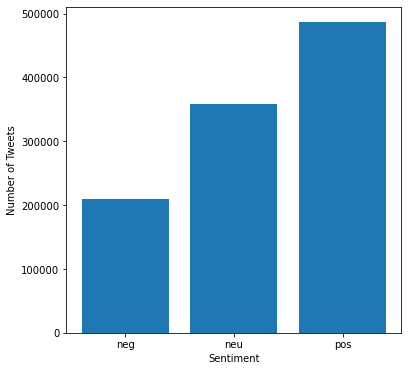

In [34]:
plt.figure(figsize=(6,6))
plt.bar(grouped_sents.size().index, grouped_sents.size().values, width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

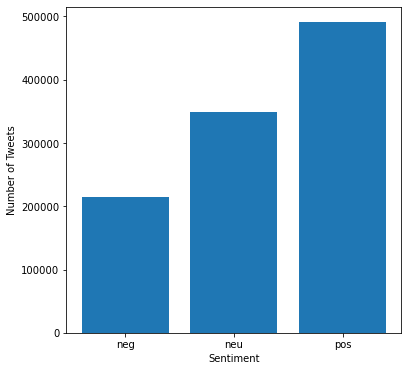

In [35]:
# Threshold as in the other paper 
def sentiment(scores):
    sents = []
    for score in scores:
        if score >= 0.001:
            sent = 'pos'
        elif score <= -0.001:
            sent = 'neg'
        elif abs(score) <0.001:
            sent = 'neu'
        sents.append(sent)
    return sents

en_tweets['sentiment'] = sentiment(en_tweets.sent_score)
grouped_sents2 = en_tweets.groupby(by='sentiment')

plt.figure(figsize=(6,6))
plt.bar(grouped_sents2.size().index, grouped_sents2.size().values, width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

### We first look if sentiment changes based on hour of the day or day of the week

In [36]:
en_tweets_time = en_tweets.dropna(subset=['utc_offset'])
pos_sents_time = en_tweets_time.loc[en_tweets_time['sentiment'] == 'pos']
neg_sents_time = en_tweets_time.loc[en_tweets_time['sentiment'] == 'neg']

In [37]:
tweet_per_h = en_tweets_time.groupby(['day','hour']).size().unstack()
pos_tweet_per_h = pos_sents_time.groupby(['day','hour']).size().unstack()
neg_tweet_per_h = neg_sents_time.groupby(['day','hour']).size().unstack()

In [38]:
new_index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat']
tweet_per_h = tweet_per_h.reindex(new_index)
pos_tweet_per_h = pos_tweet_per_h.reindex(new_index)
neg_tweet_per_h = neg_tweet_per_h.reindex(new_index)

In [39]:
colors = ['tomato', 'darkgoldenrod', 'limegreen', 'lightseagreen', 'deepskyblue', 'slateblue','magenta']

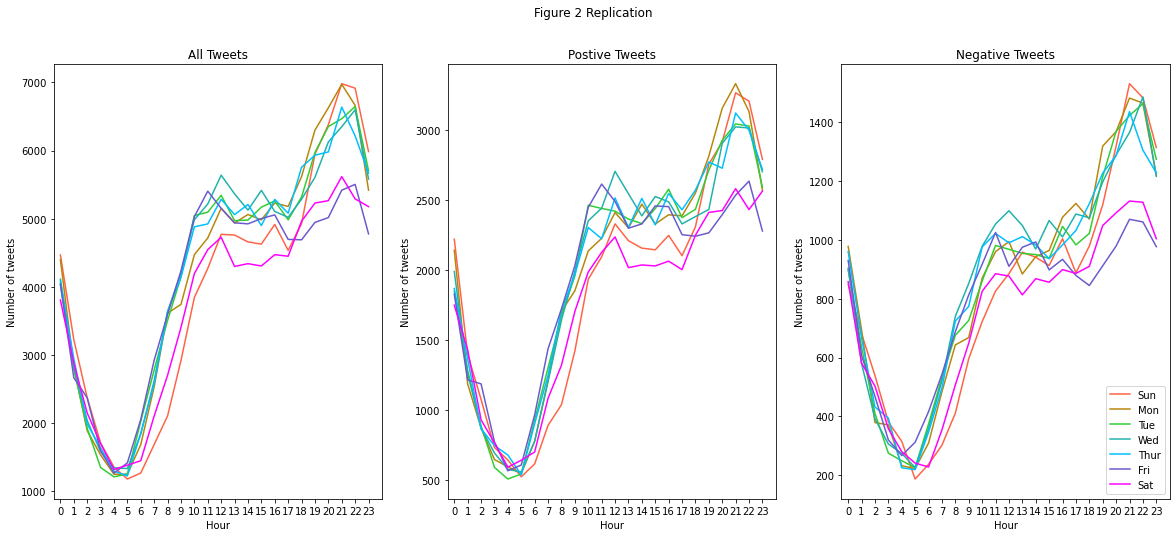

In [40]:
plt.figure(figsize=(20,8))
plt.suptitle('Figure 2 Replication')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title('All Tweets')


for i in range(7):
    plt.plot(tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title('Postive Tweets')


for i in range(7):
    plt.plot(pos_tweet_per_h.iloc[i],c=colors[i])

#plotting the reputation distribution for treated and not treated patients matched
plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title('Negative Tweets')


for i in range(7):
    plt.plot(neg_tweet_per_h.iloc[i],c=colors[i])
    plt.legend(new_index, loc='lower right')

plt.show()

We see that the positive and negative sentiment tweets have the same trend as all the tweets, so we can conclude that the day of the week or hour of the day does not have an affect on the sentiment

### Analysis of tweet sentiment on retweet count

In [41]:
pos_sents = en_tweets.loc[en_tweets['sentiment'] == 'pos']
neg_sents = en_tweets.loc[en_tweets['sentiment'] == 'neg']

Niave analysis on affect of sentiment on retweet count 

In [42]:
print("The average number of retweets for positive tweets is {:.2f}".format(pos_sents.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_sents.retweet_count.mean()))

The average number of retweets for positive tweets is 264.72
The average number of retweets for negative tweets is 177.06


In [43]:
stats.ttest_ind(pos_sents.retweet_count, neg_sents.retweet_count)

Ttest_indResult(statistic=8.836427150120006, pvalue=9.904772347653067e-19)

In [44]:
stats.mannwhitneyu(pos_sents.retweet_count, neg_sents.retweet_count)

MannwhitneyuResult(statistic=52208762073.5, pvalue=2.6556701047976775e-08)

## Not sure if the statistical tests above make sense

In [45]:
pos_sents['retweet_count'].describe()

count    491006.000000
mean        264.721500
std        4156.538755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      551788.000000
Name: retweet_count, dtype: float64

In [46]:
neg_sents['retweet_count'].describe()

count    213963.000000
mean        177.060295
std        2945.373605
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      426173.000000
Name: retweet_count, dtype: float64

In [47]:
pos_sents.sort_values(by=['retweet_count'], ascending = False)['retweet_count'].head(10)

296296    551788
635279    548016
911841    473644
391055    337006
491567    322409
712406    309553
960803    298331
249349    297234
121048    284859
324354    274359
Name: retweet_count, dtype: int64

In [48]:
neg_sents.sort_values(by=['retweet_count'], ascending = False)['retweet_count'].head(10)

516541    426173
635441    290667
635199    237713
282273    226724
635294    201765
281781    196806
120998    181591
324272    178398
326273    169294
424413    167615
Name: retweet_count, dtype: int64

When looking at simple statistics, we see that positive sentiment tweets have a much larger standard deviation, so there is more likely a significantly larger number of tweets with large retweet counts. Also, looking at the top 10 highest retweeted tweets for positive tweets we find that positive tweets have higher max retween count. So, we need to try and filter the data to avoid effects of these very popular tweets

In [49]:
pos_sents_filtered = pos_sents.loc[pos_sents['retweet_count']<1000]
neg_sents_filtered = neg_sents.loc[neg_sents['retweet_count']<1000]

In [50]:
len(neg_sents_filtered)

209532

In [51]:
print("The average number of retweets for positive tweets is {:.2f}".format(pos_sents_filtered.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_sents_filtered.retweet_count.mean()))

The average number of retweets for positive tweets is 12.98
The average number of retweets for negative tweets is 14.46


In [52]:
stats.ttest_ind(pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count)

Ttest_indResult(statistic=-7.0892444652205, pvalue=1.3497451930110384e-12)

In [53]:
stats.mannwhitneyu(pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count)

MannwhitneyuResult(statistic=49916930617.5, pvalue=7.984214306830045e-13)

However, we may find that the tweets with 0 retweets affect the data. Let's look at tweets with at least one retweet

In [54]:
pos_sents_filtered = pos_sents.loc[(pos_sents['retweet_count']<1000) & (pos_sents['retweet_count'])>0]
neg_sents_filtered = neg_sents.loc[(neg_sents['retweet_count']<1000) & (neg_sents['retweet_count']>0)]

In [55]:
print("The average number of retweets for positive tweets is {:.2f}".format(pos_sents_filtered.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_sents_filtered.retweet_count.mean()))

The average number of retweets for positive tweets is 44.40
The average number of retweets for negative tweets is 63.40


In [56]:
stats.ttest_ind(pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count)

Ttest_indResult(statistic=-21.31152110906824, pvalue=1.3722038280667173e-100)

In [57]:
stats.mannwhitneyu(pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count)

MannwhitneyuResult(statistic=1382395296.5, pvalue=0.0)

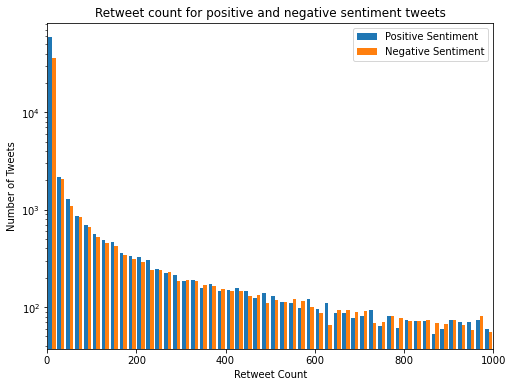

In [58]:
plt.figure(figsize=(8,6))

plt.hist([pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count], bins=50, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets')
plt.yscale('log')
plt.xlim([0, 1000])
plt.show()

It looks like the distribution of retweet count is very similar for both positive and negative tweets. However, there is a much larger set of positive tweets. Let's look at set of the same size

In [59]:
pos_same_size = pos_sents_filtered.sample(len(neg_sents_filtered))

print("Now we look at {} postive tweets and {} negative tweets".format(len(pos_same_size),len(neg_sents_filtered)))

Now we look at 47787 postive tweets and 47787 negative tweets


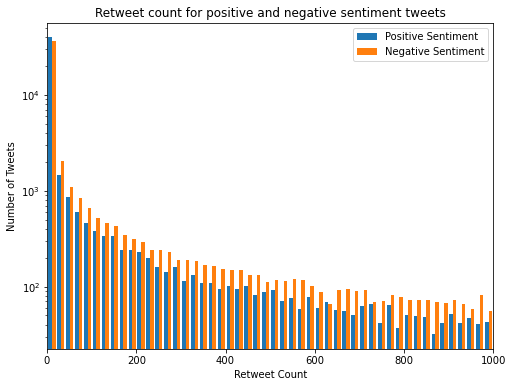

In [60]:
plt.figure(figsize=(8,6))

plt.hist([pos_same_size.retweet_count, neg_sents_filtered.retweet_count], bins=50, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets')
plt.yscale('log')
plt.xlim([0, 1000])
plt.show()

From this distribution, we start to see that negative tweets tend to perform better in terms of retweet count.

## A look into retweetability 

In [61]:
perc_neg_ret = (len(neg_sents.loc[neg_sents['retweet_count']>0])/len(neg_sents))* 100
perc_pos_ret = (len(pos_sents.loc[pos_sents['retweet_count']>0])/len(pos_sents))* 100

print("{:.2f}% of positive tweets were retweeted and {:.2f}% of negative tweets were retweeted".format(perc_pos_ret,perc_neg_ret))

23.79% of positive tweets were retweeted and 24.41% of negative tweets were retweeted


In [62]:
en_tweets.groupby(["user_name"]).count()['clean_tweets']

user_name
  ♥ AaLiYaH ♥       82
 almer               2
 angieespino         2
 niallcumming        4
 العابرون            7
                  ... 
🕊                 2101
🗝                 1661
🦇 Trîstãn 🦇          1
🦊🐥🐰🐶🐱🐹              29
🧍‍♀️              2740
Name: clean_tweets, Length: 6167, dtype: int64

In [63]:
sent_follow = en_tweets.groupby(["user_name"]).apply(lambda x:  pd.Series({
        'total_tweets': x['clean_tweets'].count(),
        'pos_tweets': len(x.loc[x['sentiment'] == 'pos']),
        'neg_tweets': len(x.loc[x['sentiment'] == 'neg']),
        'num_followers': x['user_followers_count'].max(),
        'num_friends': x['user_friends_count'].max()
    }))

sent_follow.head(3)

,total_tweets,pos_tweets,neg_tweets,num_followers,num_friends
user_name,,,,,
♥ AaLiYaH ♥,82,44,21,4,70
almer,2,1,0,3,26
angieespino,2,2,0,0,2


In [64]:
print("Before filtering we have {} users to compare".format(len(sent_follow)))

Before filtering we have 6167 users to compare


In [65]:
sent_follow_filtered = sent_follow.loc[(sent_follow['total_tweets'] > 20) &
                                      (sent_follow['pos_tweets'] > 1) &
                                      (sent_follow['neg_tweets'] >1)]

In [66]:
print("After filtering we have {} users to compare".format(len(sent_follow_filtered)))

After filtering we have 1838 users to compare


In [67]:
sent_follow_filtered['pos_perc'] = (sent_follow_filtered['pos_tweets']/sent_follow_filtered['total_tweets'])*100
sent_follow_filtered['neg_perc'] = (sent_follow_filtered['neg_tweets']/sent_follow_filtered['total_tweets'])*100

In [68]:
sent_follow_filtered.head(3)

,total_tweets,pos_tweets,neg_tweets,num_followers,num_friends,pos_perc,neg_perc
user_name,,,,,,,
♥ AaLiYaH ♥,82,44,21,4,70,53.658537,25.609756
!KING!,304,92,67,48,234,30.263158,22.039474
#EndSARS,181,97,43,134,158,53.591160,23.756906


In [69]:
kk = sent_follow_filtered.groupby('num_followers').agg({"neg_perc":"mean", "pos_perc":"mean"})


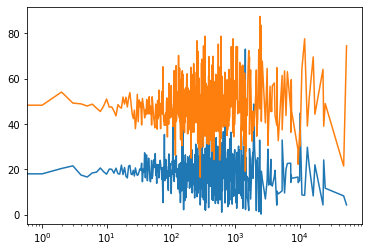

In [70]:
plt.plot(kk.index,kk.neg_perc)
plt.plot(kk.index,kk.pos_perc)
plt.xscale('log')

(0.0, 5000.0)

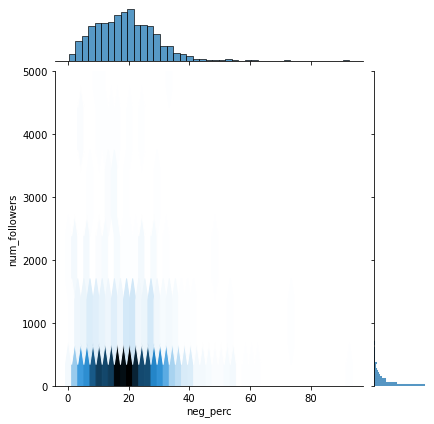

In [71]:

sns.jointplot(sent_follow_filtered['neg_perc'], sent_follow_filtered['num_followers'], kind="hex")
plt.ylim(0,5000)



(0.0, 2500.0)

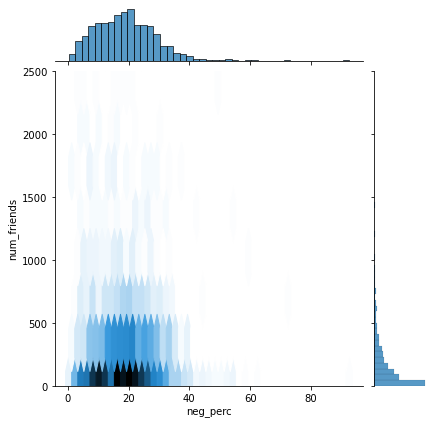

In [72]:
sns.jointplot(sent_follow_filtered['neg_perc'], sent_follow_filtered['num_friends'], kind="hex")
plt.ylim(0,2500)


(0.0, 5000.0)

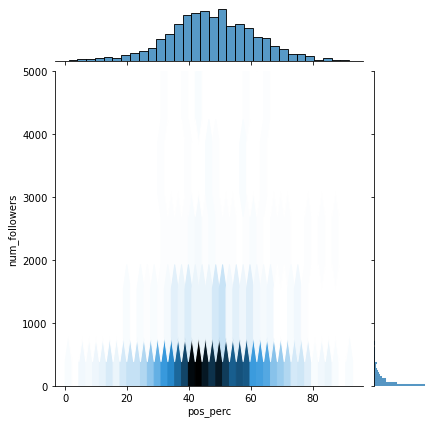

In [73]:
sns.jointplot(sent_follow_filtered['pos_perc'], sent_follow_filtered['num_followers'], kind="hex")
plt.ylim(0,5000)

(0.0, 2500.0)

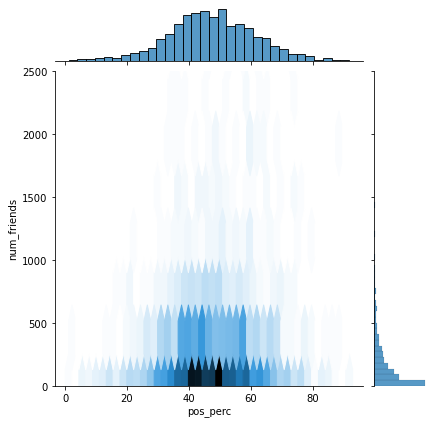

In [74]:
sns.jointplot(sent_follow_filtered['pos_perc'], sent_follow_filtered['num_friends'], kind="hex")
plt.ylim(0,2500)

## Topic Analysis 

**Empath lexicon**

We are going to use [*Empath*](https://github.com/Ejhfast/empath-client), a tool for analyzing text across lexical categories. It will be used to extract tweets that can be related to a certain topic.

In [75]:
lexicon = Empath()

We show an example of usage for two different sentences

In [76]:
example_1 = "We love playing basketball"
example_2 = "We love playing the guitar"
for ex in [example_1, example_2]:
    print(f"Sentence:\t{ex}")
    print(f"Result:\t\t{lexicon.analyze(ex, categories = ['sports', 'music'])}")
    print(f"Normalized result:\t{lexicon.analyze(ex, categories = ['sports', 'music'], normalize = True)}\n")
    
print("Explanation: 'playing' and 'basketball' are in the sports keyword set,"
      " whereas 'guitar' falls into the music keywords set.")

Sentence:	We love playing basketball
Result:		{'sports': 2.0, 'music': 0.0}
Normalized result:	{'sports': 0.5, 'music': 0.0}

Sentence:	We love playing the guitar
Result:		{'sports': 1.0, 'music': 1.0}
Normalized result:	{'sports': 0.2, 'music': 0.2}

Explanation: 'playing' and 'basketball' are in the sports keyword set, whereas 'guitar' falls into the music keywords set.


**Lexical Categories**

In [77]:
categories = list(lexicon.cats.keys())
categories.sort()
print(f"There are {len(categories)} predefined categories.\nSome of the categories are: {categories[:20] + ['...']}")
print(f"\nEach category contains a set of keywords:\nsports: {lexicon.cats['sports'][:20] + ['...']}")

There are 196 predefined categories.
Some of the categories are: ['achievement', 'affection', 'aggression', 'air_travel', 'alcohol', 'ancient', 'anger', 'animal', 'anonymity', 'anticipation', 'appearance', 'art', 'attractive', 'banking', 'beach', 'beauty', 'blue_collar_job', 'body', 'breaking', 'business', '...']

Each category contains a set of keywords:
sports: ['dribble', 'sporting', 'cheerleading', 'jock', 'warmup', 'runner', 'wrestling', 'athletic', 'captain', 'hitter', 'handball', 'playoff', 'surf', 'competition', 'bowling', 'skiing', 'snowboarding', 'sneaker', 'yoga', 'spectator', '...']


We will select 8 of these categories:<br>*sports, politics, music, religion, health, cooking, fashion, and family*

In [78]:
CATEGORIES = ["sports", "politics", "music", "religion", "health", "cooking", "fashion", "family"]

**Computing topic extraction**

Let's compute the category scores for each tweet, and then select the most probable category if any detected. Or load the already computed dataset (saving time).

In [80]:
categorized_dataset = 'Data/categorized_tweets.csv'
load_df = False

if not os.path.isfile(categorized_dataset) or not load_df:
    
    def score_categories(x, cats=CATEGORIES):
        cat_scores = lexicon.analyze(x.text, categories = cats)
        return [int(x) for x in list(cat_scores.values())]

    df_cats = en_tweets.apply(score_categories, axis=1)
    df_cats = pd.DataFrame(df_cats.to_list(), index=df_cats.index, columns=CATEGORIES)
    en_tweets = en_tweets.join(df_cats)

    # Extracting the category with the maximum number of occurrences
    def max_category(x, cats=CATEGORIES):
        array = [x[cat] for cat in cats]
        if np.sum(array) == 0:
            res = np.nan
        elif array.count(max(array)) > 1:
            res = np.nan
        else:
            res = cats[np.argmax(array)]
        return res

    en_tweets['category'] = en_tweets[CATEGORIES].apply(max_category, axis=1)
    
    # Write dataset
    en_tweets.to_csv(categorized_dataset, index=False)
    
# Read already created dataset
elif os.path.isfile(categorized_dataset) and 'category' not in df.columns and load_df:
    en_tweets = pd.read_csv(categorized_dataset)

KeyboardInterrupt: 

For each category, we have counted the number of keywords present in the text. Then, the category with more keywords is considered the actual category of the tweet.

In [ ]:
print(f"{en_tweets['category'].isna().value_counts()[False]} tweets were categorized;"
      f" {en_tweets['category'].isna().value_counts()[False]/len(df)*100:.2f}% of the total {len(en_tweets)} tweets.")

Categorized tweets keyword count:

In [9]:
en_tweets[en_tweets.columns[-(len(CATEGORIES)+1):]][~en_tweets['category'].isna()].sample(n=4, random_state=0)

,sports,politics,music,religion,health,cooking,fashion,family,category
156741,0,0,0,0,0,0,1,0,fashion
1408686,0,0,0,0,0,0,0,1,family
515334,0,0,0,0,0,0,0,1,family
1315816,1,0,0,0,0,0,0,0,sports


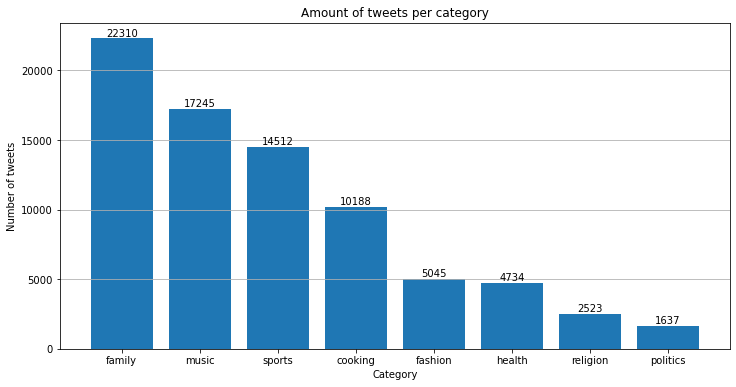

In [10]:
counts_series = en_tweets['category'].value_counts()

plt.figure(figsize=(12,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.grid(axis='y')
plt.title('Amount of tweets per category')
plt.ylabel('Number of tweets')
plt.xlabel('Category')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

## Group statistics

In [11]:
group_stats =   (en_tweets[['category', 'text', 'retweet_count', 'favorite_count', 'retweetability']]
                 .groupby('category')
                 .agg({'text':'count', 'retweet_count':['mean', 'std'], 'retweetability':'mean', 'favorite_count':['mean', 'std']})
                 .sort_values(('retweet_count', 'mean'), ascending=False)
                )

In [12]:
def highlight_max(data): #, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold'
    #attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [13]:
group_stats.style.apply(highlight_max, axis=0)# % 'bold')

## Showing some of the tweets

In [14]:
def sample_tweets(cat, N=10, seed=None, min_rt=0):
    df_w = (en_tweets[(en_tweets['category']==cat) & (en_tweets['retweet_count'] > min_rt)]
            [['retweet_count', 'favorite_count', 'text', 'user_name']]
           )
    for rt, fav, tweet, user in df_w.sample(n=min(N, len(df_w)), random_state=None).values:
        print(f"RTs: {str(rt).ljust(4)}\tFavs: {str(fav).ljust(4)}\tUser: {user.ljust(15)} Tweet: {tweet}")

In [20]:
sample_tweets('religion', min_rt=10)

RTs: 41  	Favs: 33  	User: Grace + Grit    Tweet: Y'all worship Beyonce but won't worship God
RTs: 12  	Favs: 7   	User: Grace + Grit    Tweet: No sin is worth going to hell for
RTs: 55  	Favs: 29  	User: Carl Sagan      Tweet: "For a long time the human instinct to understand was thwarted by facile religious explanations."
RTs: 21  	Favs: 13  	User: SEBTS           Tweet: If you are able to attend church but do not, then you are living in sin. @MarkDever #9MarksSE
RTs: 27  	Favs: 1   	User: sagittarius's   Tweet: many others are far below us.. come to pray and give thanks!! #SAGITARIUS
RTs: 12  	Favs: 3   	User: ▲ ada aku kesah ▲ Tweet: I'm sorry Palestina. I'm here watching your bloods flow, tears drop, broken hearts thru pictures/news. All I can do is pray for u I'm sorry
RTs: 18  	Favs: 5   	User: Cherry Deeky    Tweet: I'm a FIRM believer in Karma. What you do to someone will come back and attack you 500 times worse. Be careful how you treat people.
RTs: 15  	Favs: 9   	User: SEBT

> Pre-processing to remove repeated tweets. Cameron? Consistency with the other parts of the project

## Statistical Evaluation

We look at the statistics of `retweet_count`and `favorite_count`:
1. **mean value** with its bootstrap confidence intervals.
2. **Expected log value** with its bootstrap confidence intervals too.

The second statistic is related to the fact that the distributions are similar to the power law distribution, and the expected log value is a sufficient statistic for the power law (Idea from [stats.stackexchange](https://stats.stackexchange.com/questions/121925/intuitive-descriptive-statistics-for-power-law-distributions)).

In [16]:
def bootstrap_stat_ci(array, statistic, repetitions=10000, alpha=0.05, resampling_size=None):
    if resampling_size is None:
        resampling_size = int(len(array))
    
    # For reproducibility
    np.random.seed(seed=0)
    
    bootstrap_distribution = []
    for i in range(repetitions):
        # resampled data
        bootstrap_sample = np.random.choice(array, size=resampling_size, replace=True)
        # computing the mean
        stat_sample = statistic(bootstrap_sample)
        # saving the statistic into the bootstrap distribution
        bootstrap_distribution.append(stat_sample)

    # Computing the bootstrap confidence interval
    mean = np.mean(bootstrap_distribution)
    left = np.percentile(bootstrap_distribution, alpha/2*100)
    right = np.percentile(bootstrap_distribution, (1-alpha/2)*100)
    
    return bootstrap_distribution, mean, (left, right)

def compute_statistic(statistic, categories, feature='retweet_count'):
    # Choosing statistic
    if statistic == 'mean':
        stat_func = lambda x: np.mean(x)
    elif statistic == 'mean_log':
        stat_func = lambda x: np.mean(np.log10(x))
    
    # Computing bootstrap ci per category
    x, l_err, r_err = [], [], []
    for cat in categories:
        values = df[df['category']==cat][feature][df[feature]>0].values
        _, mean, (l_ci, r_ci) = bootstrap_stat_ci(values, statistic=stat_func)
        x.append(mean)
        l_err.append(mean-l_ci)
        r_err.append(r_ci-mean)
    err = [l_err, r_err]
    return x, err

def plot_error_bar(x, err, categories, statistic_name=''):
    y = np.linspace(1, 2*len(x)-1, len(x))
    plt.figure(figsize=(10,5))
    plt.errorbar(x, y, xerr=err, fmt = 'o', color = 'k')
    plt.yticks(tuple([0] + list(y) + [y[-1]+1]), tuple([''] + categories + ['']))
    plt.title(statistic_name + ' per Category')
    plt.ylabel('Categories')
    plt.xlabel(statistic_name)
    plt.show()
    
def show(statistic, feature, categories):
    x, err = compute_statistic(statistic, categories, feature)
    plot_error_bar(x, err, categories, statistic_name=' '.join([x.replace('_', ' ').title() for x in [statistic, feature]]))

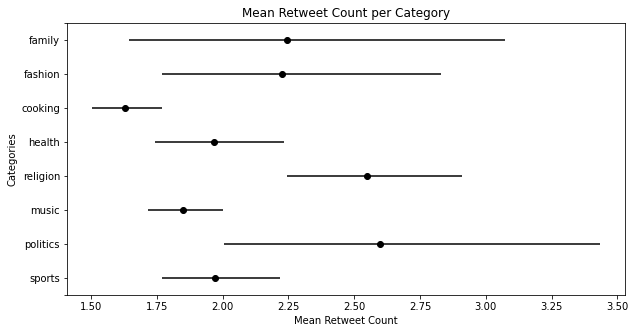

In [17]:
show('mean', 'retweet_count', CATEGORIES)

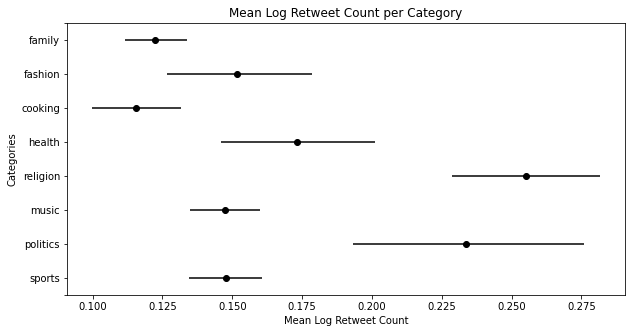

In [18]:
show('mean_log', 'retweet_count', CATEGORIES)

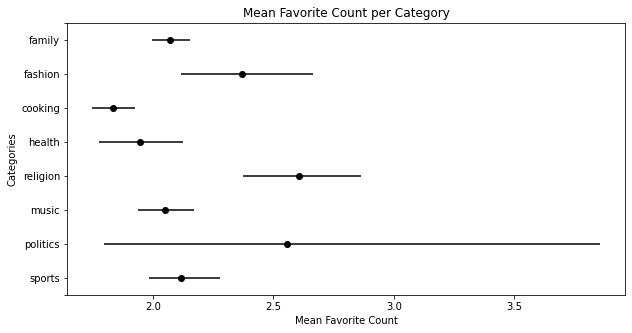

In [19]:
show('mean', 'favorite_count', CATEGORIES)

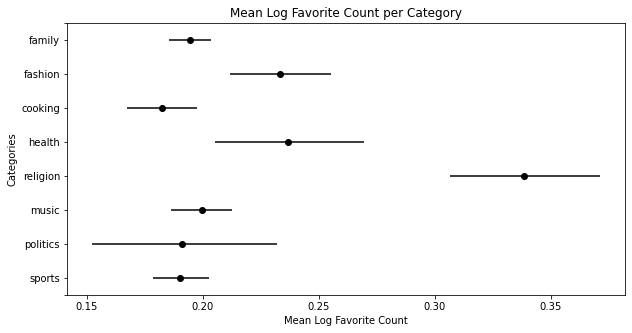

In [26]:
show('mean_log', 'favorite_count', CATEGORIES)

---------------
# EXTRA CODE

## Plotting retweet and favorite distributions

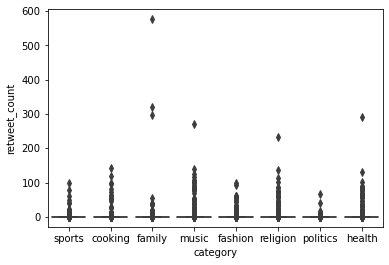

In [13]:
ax = sns.boxplot(x="category", y="retweet_count", data=df)

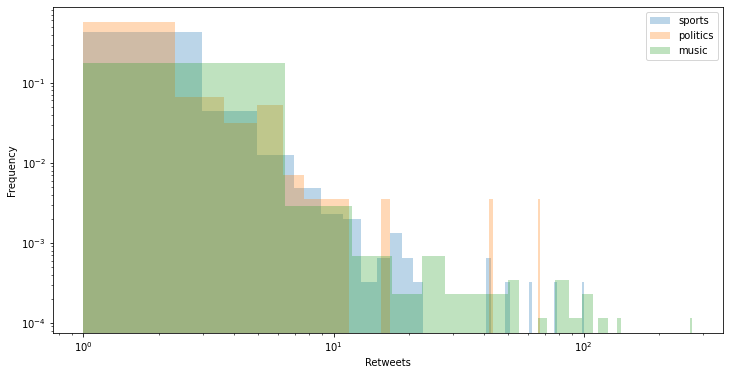

In [21]:
categories = CATEGORIES[:3]

plt.figure(figsize=(12,6))
for cat in categories:
    plt.hist(df[df['category']==cat]['retweet_count'][df['retweet_count']>0].values, bins=50, alpha=0.3, density=True)
plt.legend(categories)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Retweets')
plt.ylabel('Frequency')
plt.show()

**Fitting a power law**

Its pdf is \\( f(x,a) = ax^{a-1} \\)

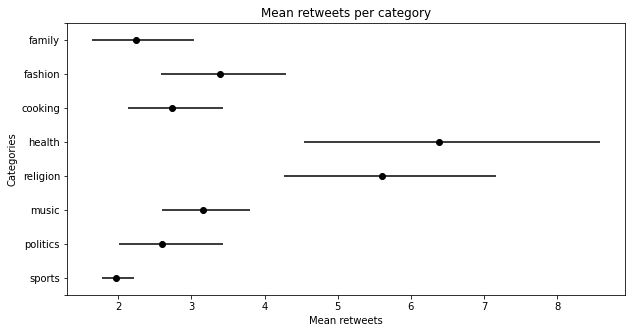

In [76]:
plot_error_bar(x, err, statistic_name='Mean retweets')

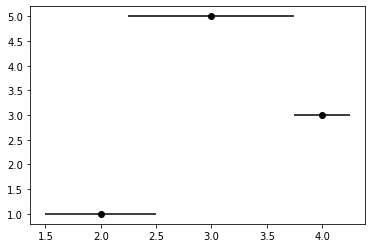

In [64]:
x = [2, 4, 3]
y = np.linspace(1, 2*len(x)-1, len(x))
errors = [0.5, 0.25, 0.75]

plt.figure()
plt.errorbar(x, y, xerr=errors, fmt = 'o', color = 'k')
#plt.yticks((0, 1, 3, 5, 6), ('', 'x3', 'x2', 'x1',''))
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1309f04c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1309f0b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1309f0160>],
 'medians': [<matplotlib.lines.Line2D at 0x1309f2280>],
 'fliers': [<matplotlib.lines.Line2D at 0x1309f2580>],
 'means': []}

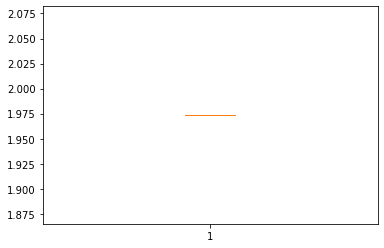

In [47]:
plt.boxplot(mean, conf_intervals=[[l_ci, r_ci])

{'whiskers': [<matplotlib.lines.Line2D at 0x13bb46b80>,
 'caps': [<matplotlib.lines.Line2D at 0x137feb2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13bb46820>],
 'medians': [<matplotlib.lines.Line2D at 0x137feb9a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x137febca0>],
 'means': []}

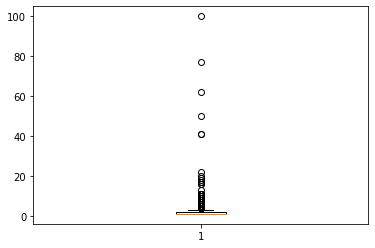

In [42]:
plt.boxplot(rt_sports, bootstrap=10000)

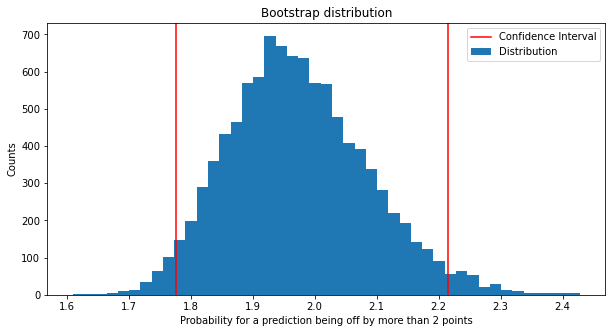

In [61]:
# Plotting the bootstrap distribution

plt.figure(figsize=(10,5))
plt.hist(bootstrap_distribution, bins=45)
plt.title('Bootstrap distribution')
plt.ylabel('Counts')
plt.xlabel('Probability for a prediction being off by more than 2 points')
plt.axvline(x=left, color='red')
plt.legend(['Confidence Interval', 'Distribution'])
plt.axvline(x=right, color='red')
plt.show()

In [26]:
scipy.stats.powerlaw.fit(rt_sports)

(0.20062570982506292, 0.9999999999999998, 107.3392646686593)

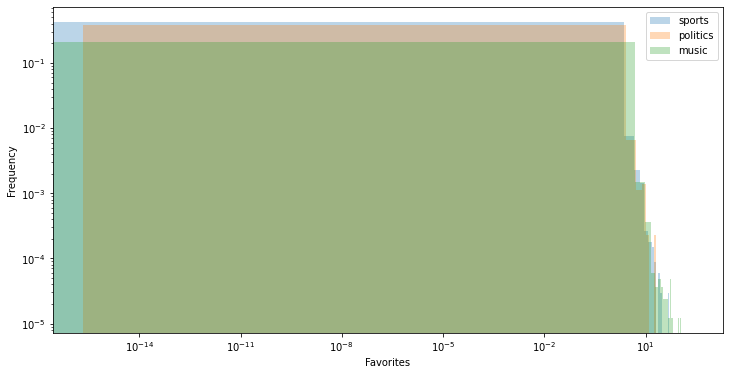

In [20]:
categories = CATEGORIES

plt.figure(figsize=(12,6))
for cat in categories:
    plt.hist(df[df['category']==cat]['favorite_count'].values, bins=50, alpha=0.3, density=True)
plt.legend(categories)
plt.yscale('log')
plt.xlabel('Favorites')
plt.ylabel('Frequency')
plt.show()

# Bert SA-pipeline

In [73]:
sa_pipeline = pipeline('sentiment-analysis')

In [72]:
for i in range(10):
    text = en_tweets['text'].iloc[i]
    print(text)
    prediction = sa_pipeline(text)
    print(prediction)
    print()

Will try to live for a week offline... wish me luck! :D
[{'label': 'POSITIVE', 'score': 0.866500198841095}]

Boa tarde..
 (@shekinahbiscuit live on http://t.co/nU1N0NJJIJ)
[{'label': 'NEGATIVE', 'score': 0.9955581426620483}]

Phew... Valentine's day will be finally over in few hours
[{'label': 'NEGATIVE', 'score': 0.9857021570205688}]

up
 (@deiabiscuit32 live on http://t.co/J8uYVfLR)
[{'label': 'NEGATIVE', 'score': 0.9937337636947632}]

simmm
 (@deiabiscuit32 live on http://t.co/J8uYVfLR)
[{'label': 'NEGATIVE', 'score': 0.9974138140678406}]

ski everybody! (rock)
[{'label': 'POSITIVE', 'score': 0.9946964383125305}]

Wonders why there are so many ugly fat women on maury with sexy whores of men... How did that happen?!
[{'label': 'NEGATIVE', 'score': 0.9961680769920349}]

A new iOS version of #SmurfLife has arrived with new trainers &amp; quests! Update now to join the fun! @BeelineGames http://t.co/H2ugkjbBwZ
[{'label': 'POSITIVE', 'score': 0.9560735821723938}]

Have you been to the mo

----------------
# Extra code

-------------

## Results with the raw tweets

In [73]:
#Initializing the Rule-based sentiment analyzer 
analyzer = SentimentIntensityAnalyzer()

In [74]:
en_tweets['sent_score'] = [analyzer.polarity_scores(x)['compound'] for x in en_tweets['text']]

In [75]:
def sentiment(scores):
    sents = []
    for score in scores:
        if score >=0.05:
            sent = 'pos'
        elif score <=-0.05:
            sent = 'neg'
        elif abs(score) <0.05:
            sent = 'neu'
        sents.append(sent)
    return sents

In [76]:
en_tweets['sentiment'] = sentiment(en_tweets.sent_score)

In [77]:
grouped_sents = en_tweets.groupby(by='sentiment')

In [78]:
print('Number of positive sentences:',sum(np.array(en_tweets['sent_score'])>=0.05))
print('Number of negative sentences:',sum(np.array(en_tweets['sent_score'])<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(en_tweets['sent_score']))<0.05))

Number of positive sentences: 485976
Number of negative sentences: 210152
Number of neutral sentences: 358491


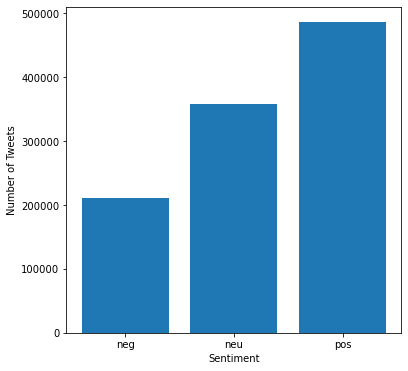

In [79]:
plt.figure(figsize=(6,6))
plt.bar(grouped_sents.size().index, grouped_sents.size().values, width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()